In [16]:
# 2D Lid-driven Cavity
# STREAMFUNCTION-VORTICITY FORMULATION
# Written by Mr A. J. Brierley
# Cranfield University, Bedfordshire, UK
# 03/06/2025


In [17]:
import numpy as np
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import cm
plt.rcParams['animation.html'] = 'html5'

In [18]:
nx = 26
ny = 26
lx = 1.0
ly = 1.0
dx = lx/(nx-1)
dy = ly/(ny-1)

In [19]:
Ut = 3.2 # top wall velocity

In [20]:
# Specify initial values for the streamfunction (psi) and vorticity (Omega)
# at t = 0 on the whole domain
# Then specify conditions that will produce values at the boundaries at t = 0
# And be enforced as the solution is marched through time
psi0 = np.zeros([nx,ny])
w0 = np.zeros([nx,ny])

# STREAMFUNCTION BOUNDARY CONDITIONS
psi_wall = 0.0

# VORTICITY BOUNDARY CONDITIONS 
# Notation: w0[j,i]
# First-order finite difference
w0[:,0] = 2.0*(psi_wall - psi0[:,1])/dx/dx                # left wall
w0[:,-1] = 2.0*(psi_wall - psi0[:,-2])/dx/dx              # right wall
w0[0,:] = 2.0*(psi_wall - psi0[1,:])/dy/dy                # bottom wall
w0[-1,:] = 2.0*(psi_wall - psi0[-2,:])/dy/dy - 2.0*Ut/dy  # top wall 

# Solution storage
psisol = []
psisol.append(psi0)
wsol = []
wsol.append(w0)

In [21]:
# print(w0)

In [22]:
# simulation parameters
beta = 1.5
tol = 1e-3
maxIt = 30

t = 0.0  # initial time and time counter
v = 0.05  # nu
dt = min(0.25*dx*dx/v, 4*v/Ut/Ut)
tend = 1000*dt
print('dt =', dt, 's')
print('Re =', Ut*lx/v)


dt = 0.008 s
Re = 64.0


In [23]:
while t < tend:
    
    #------------------------------------
    # STREAMFUNCTION-POISSON EQUATION
    #------------------------------------
    
    it = 0
    err = 1e5
    wn = wsol[-1]
    psi = psisol[-1].copy()
    while err > tol and it < maxIt:
        # psik is used for the sole purpose of calculating the error in one iteration compared to the last
        psik = np.zeros_like(psi)
        psik[1:-1, 1:-1] = psi[1:-1, 1:-1]
        for i in range(1,nx-1):
            for j in  range(1,ny-1):
                rhs = (dx*dy)**2*wn[j,i] + dy**2*(psi[j,i+1]+ psi[j,i-1]) + dx**2*(psi[j+1,i] + psi[j-1,i])
                rhs *= beta/2.0/(dx**2 + dy**2)
                psi[j,i] = rhs + (1 - beta)*psi[j,i]
        err = np.linalg.norm(psi.ravel() - psik.ravel())
        it += 1
        # print(it)
    psisol.append(psi)

    w = np.zeros_like(wn)

    #-------------------------------------
    # 2D VORTICITY TRANSPORT EQUATION
    #-------------------------------------
    
    Cx = -(psi[2:,1:-1] - psi[:-2,1:-1])/2.0/dy * (wn[1:-1,2:] - wn[1:-1,:-2])/2.0/dx
    Cy = (psi[1:-1,2:] - psi[1:-1,:-2])/2.0/dx * (wn[2:,1:-1] - wn[:-2,1:-1])/2.0/dy
    Dx = (wn[1:-1,2:] + wn[1:-1,:-2] - 2.0*wn[1:-1,1:-1])/dx/dx
    Dy = (wn[2:,1:-1] + wn[:-2,1:-1] - 2.0*wn[1:-1,1:-1])/dy/dy

    rhs = Cx + Cy + v*(Dx + Dy)  
    w[1:-1,1:-1] = wn[1:-1,1:-1] + dt * rhs

    # UPDATE VORTICITY BOUNDARY CONDITIONS 
    w[:,0] = 2.0*(psi_wall - psi[:,1])/dx/dx                # left wall
    w[:,-1] = 2.0*(psi_wall - psi[:,-2])/dx/dx              # right wall
    w[0,:] = 2.0*(psi_wall - psi[1,:])/dy/dy                # bottom wall
    w[-1,:] = 2.0*(psi_wall - psi[-2,:])/dy/dy - 2.0*Ut/dy  # top wall 

    wsol.append(w)
    
    t += dt
        


(np.float64(0.0), np.float64(25.0), np.float64(0.0), np.float64(25.0))

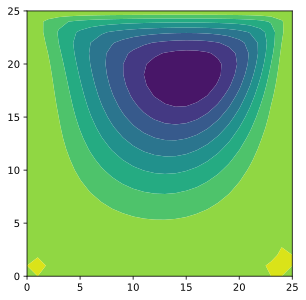

In [24]:
plt.contourf(psisol[-1])
plt.axis('square')
# plt.savefig('output.pdf', format='pdf', bbox_inches='tight')
# plt.close()

(np.float64(0.0), np.float64(25.0), np.float64(0.0), np.float64(25.0))

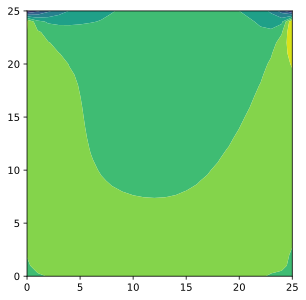

In [25]:
plt.contourf(wsol[-1])
plt.axis('square')

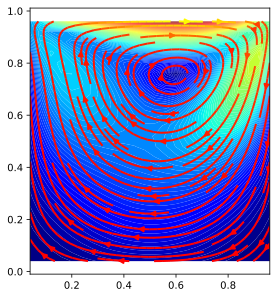

In [26]:
x = np.linspace(0,1,nx)
y = np.linspace(0,1,ny)
xx,yy = np.meshgrid(x,y)
nn = 1
psi = psisol[-1]
u = (psi[2:,1:-1] - psi[:-2,1:-1])/2.0/dy
v = -(psi[1:-1, 2:] - psi[1:-1,:-2])/2.0/dx

# print(u)
# print(v)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.contourf(xx[1:-1,1:-1], yy[1:-1,1:-1], np.sqrt(u*u + v*v), levels = 100, cmap=plt.cm.jet)
ax.streamplot(xx[1:-1,1:-1],yy[1:-1,1:-1],u, v, color=abs(u*u + v*v),cmap=plt.cm.autumn, linewidth=2)
ax.set_xlim([xx[0,1],xx[0,-2]])
ax.set_aspect(1)


In [34]:
import pyvista as pv

data = psisol[-1]  # Extract the final 2D slice from a 3D time-series array of psisol
solx, soly = data.shape  # Ensure data is in a 2D array
# Create a uniform 2D grid in pyvista for visualising the data
grid = pv.ImageData(dimensions=(solx,soly, 1))  # (single z layer)
grid.point_data["psisol"] = data.ravel(order="F")  # Assign flattened data (Fortran style) to grid points
grid.save("psisol.vtk")

In [35]:
print(psisol[-1].shape)

(26, 26)


In [32]:
print(data)

[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  2.45060785e-05 -7.58853237e-06 -1.13540492e-04
  -2.80798636e-04 -4.89424339e-04 -7.19861907e-04 -9.54996726e-04
  -1.18011007e-03 -1.38225269e-03 -1.54971641e-03 -1.67189840e-03
  -1.73964385e-03 -1.74601728e-03 -1.68735590e-03 -1.56438643e-03
  -1.38314190e-03 -1.15540909e-03 -8.98480197e-04 -6.34080177e-04
  -3.86470025e-04 -1.79820552e-04 -3.48665931e-05  3.56997549e-05
   3.52186790e-05  0.00000000e+00]
 [ 0.00000000e+00 -7.29444593e-06 -2.12481363e-04 -6.44554930e-04
  -1.26677787e-03 -2.02026318e-03 -2.84341568e-03 -3.67910823e-03
  -4.4